In [3]:
import os
import cv2
import pathlib
import shutil
import numpy as np
from skimage import measure
from matplotlib import pyplot as plt
%matplotlib inline

In [48]:
def mask_file_to_contour(masks_dir, filename, simplify=True):
    mask = cv2.imread(os.path.join(masks_dir, filename))[:,:,0]
    try:
        contour = measure.find_contours(mask, 127)[0]
    except IndexError:
        return None
    if simplify:
        sdiv = measure.subdivide_polygon(contour, degree=2, preserve_ends=True)
        simple = measure.approximate_polygon(sdiv, tolerance=1.5)
        contour = simple
    klass = int(filename[-5:-4])
    return contour, klass

def mask_file_to_normalized_contours(masks_dir, filename, img_shape, simplify=True, filter_small_contours=True):
    mask = cv2.imread(os.path.join(masks_dir, filename))[:,:,0]
    try:
        contours = measure.find_contours(mask, 127)
    except IndexError:
        return None
    if filter_small_contours:
        to_delete = []
        for idx in range(len(contours)):
            # Expand numpy dimensions
            c = np.expand_dims(contours[idx].astype(np.float32), 1)
            # Convert it to UMat object
            c = cv2.UMat(c)
            area = cv2.contourArea(c)
            if area < 1000:
                to_delete.append(idx)
        contours = [v for i, v in enumerate(contours) if i not in to_delete]
    if simplify:
        for idx in range(len(contours)): 
            sdiv = measure.subdivide_polygon(contours[idx], degree=2, preserve_ends=True)
            simple = measure.approximate_polygon(sdiv, tolerance=1.5)
            contours[idx] = simple
    for contour in contours:
        contour[:,0] = contour[:,0] / img_shape[0]
        contour[:,1] = contour[:,1] / img_shape[1]
        contour[:,[1,0]] = contour[:,[0,1]]
    klass = int(filename[-5:-4]) - 1
    return [(contour, klass) for contour in contours]

In [49]:
def load_image(img_dir):
    filename = os.listdir(os.path.join(img_dir, "images"))[0]
    img = cv2.imread(os.path.join(img_dir, "images", filename))[:,:, ::-1]
    masks = [mask_file_to_contour(os.path.join(img_dir, "masks"), f) for f in os.listdir(os.path.join(img_dir, "masks"))]
    masks = [m for m in masks if m is not None]
    return img, masks

def load_masks(img_dir):
    masks = [mask_file_to_contour(os.path.join(img_dir, "masks"), f) for f in os.listdir(os.path.join(img_dir, "masks"))]
    return masks

def load_normalized_masks(img_dir):
    filename = os.listdir(os.path.join(img_dir, "images"))[0]
    img = cv2.imread(os.path.join(img_dir, "images", filename))
    masks = [mask_file_to_normalized_contours(os.path.join(img_dir, "masks"), f, img.shape) for f in os.listdir(os.path.join(img_dir, "masks"))]
    weed_masks = masks = mask_file_to_normalized_contours(os.path.join(img_dir, "masks"), os.listdir(os.path.join(img_dir, "masks"))[0], img.shape)
    can_masks = masks = mask_file_to_normalized_contours(os.path.join(img_dir, "masks"), os.listdir(os.path.join(img_dir, "masks"))[1], img.shape)
    masks = weed_masks + can_masks
    masks = [m for m in masks if m is not None]
    return masks

In [50]:
def plot_image(img, masks):
    plt.figure(figsize=(10,10))
    plt.gray()
    plt.imshow(img.mean(axis=-1))
    for contour, klass in masks:
        # green: leaves
        # red: berries
        # yellow: flower
        # blue: stems
        color = ['g','r','b','y', 'c'][klass-1]
        plt.plot(*contour.swapaxes(0,1)[::-1], c=color)
    plt.show()

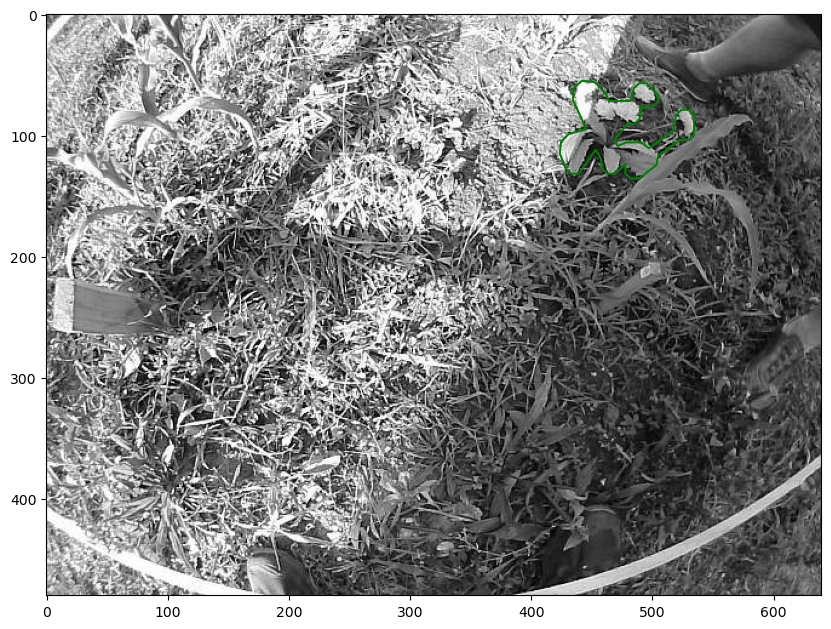

(480, 640, 3)

In [51]:
dirname = os.path.join("coco", "img_2022-05-31t18_31_07.427086")
image, masks = load_image(dirname)
plot_image(image, masks)
image.shape

In [52]:
def mv_image(img_dir: str, dest: str):
    filename = os.listdir(os.path.join(img_dir, "images"))[0]
    shutil.copy(os.path.join(img_dir, "images", filename), dest)
    
def save_masks(directory: str, img_dir: str, dest: str):
    masks = load_normalized_masks(os.path.join(directory, img_dir))
    
    # masks = list(set(masks))
    
    # masks = [(mask.flatten(), klass) for mask, klass in masks]
    # contours = [m[0] for m in masks]
    # _, c = np.unique(contours, return_index=True)
    # masks = np.delete(masks, c)
    with open(os.path.join(dest, f"{img_dir}.txt"), "w") as file:
        for mask, klass in masks:
            file.write(f"{klass} {' '.join(['%.8f' % x for x in mask.flatten()])}" + "\n")
            
def put_files_in_txt(directory: str, dest: str, filename: str):
    with open(os.path.join(dest, filename), "w") as file:
        file.write("".join([os.path.join(directory, subdir).replace("/coco2", "") + "\n" for subdir in os.listdir(directory)]))

In [54]:
def save_coco(directory: str, training=0.8, validation=0.15):
    COCO = "./coco2/"
    IMG = "./coco2/images/"
    LABELS = "./coco2/labels/"
    TRAIN_IMG = "./coco2/images/train/"
    TRAIN_LABELS = "./coco2/labels/train/"
    VAL_IMG = "./coco2/images/val/"
    VAL_LABELS = "./coco2/labels/val/"
    TEST_IMG = "./coco2/images/test/"
    TEST_LABELS = "./coco2/labels/test/"

    if not os.path.exists(COCO):
        os.mkdir(COCO)
        os.mkdir(IMG)
        os.mkdir(VAL_IMG)
        os.mkdir(TRAIN_IMG)
        os.mkdir(TEST_IMG)
        os.mkdir(LABELS)
        os.mkdir(VAL_LABELS)
        os.mkdir(TRAIN_LABELS)
        os.mkdir(TEST_LABELS)
        
    subdir = os.listdir(os.path.join(directory))
    num_images = len(subdir)
    
    # training
    for img_dir in subdir[:round(num_images * training)]:
        save_masks(directory, img_dir, TRAIN_LABELS)
        mv_image(os.path.join(directory, img_dir), TRAIN_IMG)
        put_files_in_txt(TRAIN_IMG, COCO, "train.txt")
        
    # validation
    for img_dir in subdir[round(num_images * training) + 1: round(num_images * (training + validation))]:
        save_masks(directory, img_dir, VAL_LABELS)
        mv_image(os.path.join(directory, img_dir), VAL_IMG)
        put_files_in_txt(VAL_IMG, COCO, "val.txt")


    # testing
    for img_dir in subdir[round(num_images * (training + validation)) + 1:]:
        save_masks(directory, img_dir, TEST_LABELS)
        mv_image(os.path.join(directory, img_dir), TEST_IMG)
        put_files_in_txt(TEST_IMG, COCO, "test-dev.txt")

shutil.rmtree("./coco2/")
save_coco("./coco/", training=0.8, validation=0.2)
p = os.popen('./prune_duplicates.sh')

[(array([[0.92684203, 0.03150043],
       [0.92445232, 0.03132207],
       [0.92364649, 0.03039188],
       [0.92480123, 0.02935456],
       [0.9264927 , 0.02903262],
       [0.92729853, 0.03010584],
       [0.92684203, 0.03150043]]), 0), (array([[0.62636952, 0.82154619],
       [0.61667741, 0.82165388],
       [0.61273078, 0.81990174],
       ...,
       [0.6383431 , 0.81732737],
       [0.63267826, 0.81993763],
       [0.62636952, 0.82154619]]), 0), (array([[0.62373808, 0.23122813],
       [0.62373808, 0.2307284 ],
       [0.62320156, 0.23108567],
       [0.62373808, 0.23122813]]), 0), (array([[0.52214873, 0.27813888],
       [0.52306133, 0.27749557],
       [0.52247069, 0.27749585],
       [0.52308807, 0.27653032],
       [0.52271263, 0.27560125],
       [0.52161221, 0.27799642],
       [0.52214873, 0.27813888]]), 0), (array([[0.52214873, 0.27871096],
       [0.52214873, 0.27871096]]), 0), (array([[0.52300784, 0.27871096],
       [0.52300784, 0.27871096]]), 0), (array([[0.52128963, 

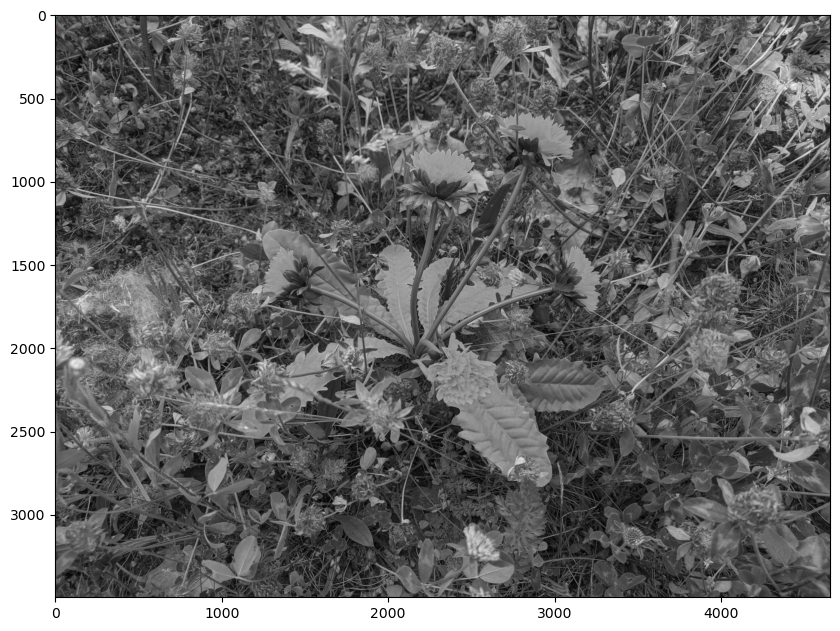

In [25]:
im = cv2.imread("./coco2/images/val/pxl_20220531_174607666.jpg")[:,:, ::-1]
contours = load_normalized_masks(os.path.join("coco", "pxl_20220531_174607666"))

# for contour in contours:
#    cv2.drawContours(im, contour, -1, (0, 255, 0), 3)
# plt.figure()
# plt.imshow(im)
print(contours)
plot_image(im, contours)